# Moving Company Exploratory Data Analysis

Imports the Google Calendar information from a moving company and describes relevant data.

We need the Python library _icalendar_ to parse the Google Calendar.

In [1]:
#!pip install icalendar

In [2]:
from icalendar import Calendar, Event

Let's create a Python dictionary to hold the data from the moving jobs

In [3]:
jobs = {}
i = 0

The text fields (summary and description) have newlines (/n) and $. We need a method for Python to correctly interpret these.

## I'm not sure I understand the notes in the DESCRIPTION field

It seems like it is some shorthand on how many hours the job took, what the hourly rate will be, how many movers are needed, etc. It's going to be difficult to parse this, but we'll take a stab at it with some regular expressions.

In some cases, I think they are listing the hourly rate. In other cases, I think they are listing the total charge. I need some sort of client decision on how to tell which is which. Of course, there are some cases where they have more than 5 movers so that might explain the high hourly rates (5 movers x \$50/hr = \$250/hr)

In [4]:
import re

'''
Extract the hourly rate
This should be in the description after the dollar sign.
However, this should be checked with the client.
I think sometimes the number is the hourly rate and other times it is the total charge.
So use a regular expression
'''
def extractRate(text):
    
    if text == None:
        return None
    
    rate = re.findall(r'[\$]{1}\d+\.?\d{0,2}',text)
    if len(rate) > 0:  # Only return first dollar amount found
        rate = float(rate[0][1:])   # Strip dollar sign and return decimal only
    else:
        rate = None
    return rate

Extract the email address of the customer

In [5]:
'''
Extract the email address of the customer
'''
def extractEmail(text):
    
    if text == None:
        return None
    
    # Regular expression to match email addresses
    email = re.findall(r'[\w+\.]*\w+@[\w.-]+|\{(?:\w+, *)+\w+\}@[\w.-]+',text.replace('\\n', ' '))
    if len(email) > 0:
        email = email[0]
    else:
        email = None
        
    return email


Search the _summary_ field for the word cancelled. Keep track of cancelled jobs.

In [6]:
'''
Determine if customer has cancelled the appointment
'''
def hasCancelled(text):
    
    if text == None:
        return None
    
    if 'cancelled' not in text.lower():
        return False
    else:
        return True


Extract the zip code

In [7]:
def extractZipCode(text):
    

    if text == None:
        return None
    
    '''
    This regex gets a tuple of full zip and 4 digits after the - 
    '''
    zips = re.findall(r'.*(\d{5}(\-\d{4})?)$', text)
    if len(zips) > 0:
        return zips[0][0]
    else:
        return None

In [8]:
def ExtractMovers(text):
    
    if text == None:
        return None
    
    text = text.lower()
    
    movers = re.findall(r'(\d+) (?:movers|mover)', text)
    if len(movers) > 0:
        return movers[0]
    else:
        return None

In [9]:
def ExtractTrucks(text):
    
    if text == None:
        return None
    
    text = text.lower()
    
    trucks = re.findall(r'(\d+) (?:trucks|truck)', text)
    if len(trucks) > 0:
        return trucks[0]
    else:
        return None

In [79]:
new_df = pd.DataFrame(list(map(lambda x: re.split(' to \d+', x), dfJobs.LOCATION)), columns = ['Origin_1', 'Destination_1', 'Destination_2', 'Destination_3'])

In [ ]:
def ExtractLocations(text):
    
    

### It looks like after September 2015, they started using a form to fill out the description

The form has customer name, phone, email, booked by, origin, destination, and all other useful fields.

For example, 
['DARNELL\\, ALAN',
 'NAME: Tian Hui Zhang ',
 'PHONE: 858-997-7729',
 'EMAIL: zzztianhui@gmail.com',
 'Booked BY: Frank on 09/21/2015',
 '',
 'ORIGIN: 7655 Palmilla Dr \#7675\\, San Diego\\, CA 92122',
 'DESTINATION:3833 Nobel Drive\\, San Diego\\, CA 92122 ',
 '',
 'SIZE: 1 Bedroom',
 'SERVICE: moving furniture and Full Pack',
 'CREW: 2 movers ',
 'TRUCKS: 1',
 'MATERIALS: standard Full Pack',
 'ESTIMATE:N/A',
 'RATE: \$88/hour - cash\\, $98/hour - card',
 'NOT TO EXCEED:N/A',
 '',
 'NOTES: Full Pack']

In [10]:
def formatPhoneNumber(text): 
    
    if text == None:
        return None
    
    if text.strip() == '':
        return None
    
    phone = text.replace('.','-')
    phone = re.sub('\/\s?', '', phone) # Remove slash /
    phone = re.sub('\(\s?', '', phone) # Remove left parenthesis (
    phone = re.sub('\)\s?', '-', phone) # Replace ) with hyphen
    
    if phone.isdigit():  # Add hyphens if not present
        phone = '{}-{}-{}'.format(phone[0:3], phone[4:6], phone[7:10])
    
    return phone
     

In [11]:
def parseDescription(text):
    
    if text == None:
        return None
    
    notes = {}
    notes['ORIGIN'] = None
    notes['ORIGIN TYPE'] = None
    notes['DESTINATION'] = None
    notes['DESTINATION TYPE'] = None
    notes['SIZE'] = None
    notes['CREW'] = None
    notes['TRUCKS'] = None
    notes['RATE'] = None
    notes['PHONE'] = None
    notes['NAME'] = None

    for item in text.split('\\n'):

        if item[0:(len('ORIGIN:'))].upper() == 'ORIGIN:':
            notes['ORIGIN'] = item[len('ORIGIN:'):].strip()
            
        if item[0:(len('Pick up Address:'))].upper() == 'PICK UP ADDRESS:':
            notes['ORIGIN'] = item[len('Pick up Address:'):].strip()
            
        if item[0:(len('Pick up Address Type:'))].upper() == 'PICK UP ADDRESS TYPE:':
            notes['ORIGIN TYPE'] = item[len('Pick up Address Type:'):].strip()    

        if item[0:(len('DESTINATION:'))].upper() == 'DESTINATION:':
            notes['DESTINATION'] =  item[len('DESTINATION:'):].strip()
            
        if item[0:(len('Drop off Address Type:'))].upper() == 'DROP OFF ADDRESS TYPE:':
            notes['DESTINATION TYPE'] = item[len('Drop off Address Type:'):].strip()    

        if item[0:(len('Drop off  Address:'))].upper() == 'DROP OFF  ADDRESS:':
            notes['DESTINATION'] = item[len('Drop off  Address:'):].strip()
            
        if item[0:(len('SIZE:'))].upper() == 'SIZE:':
            notes['SIZE'] = item[len('SIZE:'):].strip()

        if item[0:(len('CREW:'))].upper() == 'CREW:':
            notes['CREW'] = item[len('CREW:'):].strip()
            
        if item[0:(len('Crew Size:'))].upper() == 'CREW SIZE:':
            notes['CREW'] = item[len('Crew Size:'):].strip()

        if item[0:(len('TRUCKS:'))].upper() == 'TRUCKS:':
            notes['TRUCKS'] = item[len('TRUCKS:'):].strip()

        if item[0:(len('RATE:'))].upper() == 'RATE:':
            notes['RATE'] = extractRate(item[len('RATE:'):].strip())
            
        if item[0:(len('Rate and Fees:'))].upper() == 'RATE AND FEES:':
            notes['RATE'] = extractRate(item[len('Rate and Fees:'):].strip())

        if item[0:(len('PHONE:'))].upper() == 'PHONE:':
            notes['PHONE'] = formatPhoneNumber(item[len('PHONE:'):].strip())

        if item[0:(len('NAME:'))].upper() == 'NAME:':
            notes['NAME'] = item[len('NAME:'):].strip()
            
        notes['ORIGIN ZIP'] = extractZipCode(notes['ORIGIN'])
        notes['DESTINATION ZIP'] = extractZipCode(notes['DESTINATION'])
            
    return notes

In [12]:
def raw(text):
    return text

The _icalendar_ library parses the calendar. For every _event_ in the calendar, we check to see which fields are present.

In [13]:
def parseKeys(component):
    
      
    if component.has_key('DTSTART'):
            DTSTART = component.get('DTSTART').to_ical()
    else:
        DTSTART = None

    if component.has_key('DTEND'):
        DTEND = component.get('DTEND').to_ical()
    else:
        DTEND = None

    if component.has_key('RRULE'):
        RRULE = component.get('RRULE').to_ical()
    else:
        RRULE = None

    if component.has_key('DTSTAMP'):
        DTSTAMP = component.get('DTSTAMP').to_ical()
    else:
        DTSTAMP = None

    if component.has_key('UID'):
        UID = component.get('UID').to_ical()
    else:
        UID = None

    if component.has_key('CREATED'):
        CREATED = component.get('CREATED').to_ical()
    else:
        CREATED = None

    if component.has_key('DESCRIPTION'):
        DESCRIPTION = raw(component.get('DESCRIPTION').to_ical())
        EMAIL = extractEmail(DESCRIPTION)
        parsed = parseDescription(DESCRIPTION)
    else:
        DESCRIPTION = None
        EMAIL = None
        parsed = parseDescription('')

    if component.has_key('LAST-MODIFIED'):
        LASTMODIFIED = component.get('LAST-MODIFIED').to_ical()
    else:
        LASTMODIFIED = None

    if component.has_key('LOCATION'):
        LOCATION = component.get('LOCATION').to_ical()
    else:
        LOCATION = None

    if component.has_key('SEQUENCE'):
        SEQUENCE = component.get('SEQUENCE').to_ical()
    else:
        SEQUENCE = None

    if component.has_key('SUMMARY'):
        SUMMARY = raw(component.get('SUMMARY').to_ical())
        CANCELLED = hasCancelled(SUMMARY)
    else:
        SUMMARY = None
        CANCELLED = None

    if component.has_key('TRANSP'):
        TRANSP = component.get('TRANSP').to_ical()
    else:
        TRANSP = None


    NUMBERMOVERS = ExtractMovers(DESCRIPTION)
    if (NUMBERMOVERS == None):
        NUMBERMOVERS = ExtractMovers(SUMMARY)

    NUMBERTRUCKS = ExtractTrucks(DESCRIPTION)
    if (NUMBERTRUCKS == None):
        NUMBERTRUCKS = ExtractTrucks(SUMMARY)
            
    return [DTSTART,
            DTEND,
            RRULE,
            DTSTAMP,
            UID,
            CREATED,
            DESCRIPTION,
            parsed['ORIGIN'],
            parsed['ORIGIN TYPE'],
            parsed['ORIGIN ZIP'],
            parsed['DESTINATION'],
            parsed['DESTINATION TYPE'],
            parsed['DESTINATION ZIP'],
            parsed['SIZE'],
            parsed['CREW'],
            NUMBERMOVERS,
            parsed['TRUCKS'],
            NUMBERTRUCKS,
            parsed['RATE'],
            parsed['NAME'],
            parsed['PHONE'],
            EMAIL,
            LASTMODIFIED,
            LOCATION,
            SEQUENCE,
            SUMMARY,
            CANCELLED,
            TRANSP]

Now go through the file and parse the moving jobs into the dictionary

In [14]:
fileName = 'vectormovingsd@gmail.com.ics'

with open(fileName,'rb') as fp:
    gcal = Calendar.from_ical(fp.read())
    for component in gcal.walk():
    
        if component.name == 'VEVENT':
         
            jobs[i] = parseKeys(component)

            i += 1
    
fp.close()

Let's put the jobs into Pandas

In [15]:
import pandas as pd

In [16]:
dfJobs = pd.DataFrame.from_dict(jobs, orient='index')
dfJobs.columns = ['DTSTART',
                  'DTEND',
                  'RRULE',
                  'DTSTAMP',
                  'UID',
                  'CREATED',
                  'DESCRIPTION',
                  'ORIGIN',
                  'ORIGIN TYPE',
                  'ORIGIN ZIP CODE',
                  'DESTINATION',
                  'DESTINATION TYPE',
                  'DESTINATION ZIP CODE',
                  'SIZE',
                  'CREW',
                  'NUMBER OF MOVERS',
                  'TRUCKS',
                  'NUMBER OF TRUCKS',
                  'RATE',
                  'CUSTOMER NAME',
                  'CUSTOMER PHONE',
                  'CUSTOMER EMAIL',
                  'LAST MODIFIED',
                  'LOCATION',
                  'SEQUENCE',
                  'SUMMARY',
                  'CANCELLED',
                  'TRANSP']

In [17]:
del jobs   # Free up memory

Let's convert the time/date stamps to correct format.

In [18]:
dfJobs['DTSTART'] = pd.to_datetime(dfJobs['DTSTART'])
dfJobs['DTEND'] = pd.to_datetime(dfJobs['DTEND'])
dfJobs['DTSTAMP'] = pd.to_datetime(dfJobs['DTSTAMP'])
dfJobs['CREATED'] = pd.to_datetime(dfJobs['CREATED'])
dfJobs['LAST MODIFIED'] = pd.to_datetime(dfJobs['LAST MODIFIED'])

# Sanity check

Note that the DESCRIPTION and SUMMARY fields differ in the hourly rate (\$55 vs. \$60/hr)

In [19]:
dfJobs.ix[40]

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


DTSTART                                               2013-09-06 22:00:00
DTEND                                                 2013-09-06 23:00:00
RRULE                                                                None
DTSTAMP                                               2016-11-29 12:31:58
UID                                 galblf8rorplcgmdmb7aqtcst8@google.com
CREATED                                               2013-09-04 19:00:55
DESCRIPTION             yelp.com\ncholleti15@yahoo.com\n3 hours $55/hr...
ORIGIN                                                               None
ORIGIN TYPE                                                          None
ORIGIN ZIP CODE                                                      None
DESTINATION                                                          None
DESTINATION TYPE                                                     None
DESTINATION ZIP CODE                                                 None
SIZE                                  

In [20]:
dfJobs.ix[4009]

DTSTART                                               2016-12-01 22:00:00
DTEND                                                 2016-12-02 06:00:00
RRULE                                                                None
DTSTAMP                                               2016-11-29 12:31:59
UID                                 mseq63sf79542ehq1isoq6mg94@google.com
CREATED                                               2016-11-29 00:57:30
DESCRIPTION             December 1\, 2016 2:00pm PST\nCalendar: Vector...
ORIGIN                     2870 Fifth Ave. Suite 107 San Diego\, Ca 92103
ORIGIN TYPE                                                        Office
ORIGIN ZIP CODE                                                     92103
DESTINATION                                                          None
DESTINATION TYPE                                                     None
DESTINATION ZIP CODE                                                 None
SIZE                                  

In [83]:
dfJobs = pd.concat([dfJobs, new_df], join = 'outer', axis = 1)

In [84]:
#!pip install seaborn

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.ticker as ticker

import seaborn as sns
sns.set(color_codes=True)


# Plot histogram of the number of jobs per month

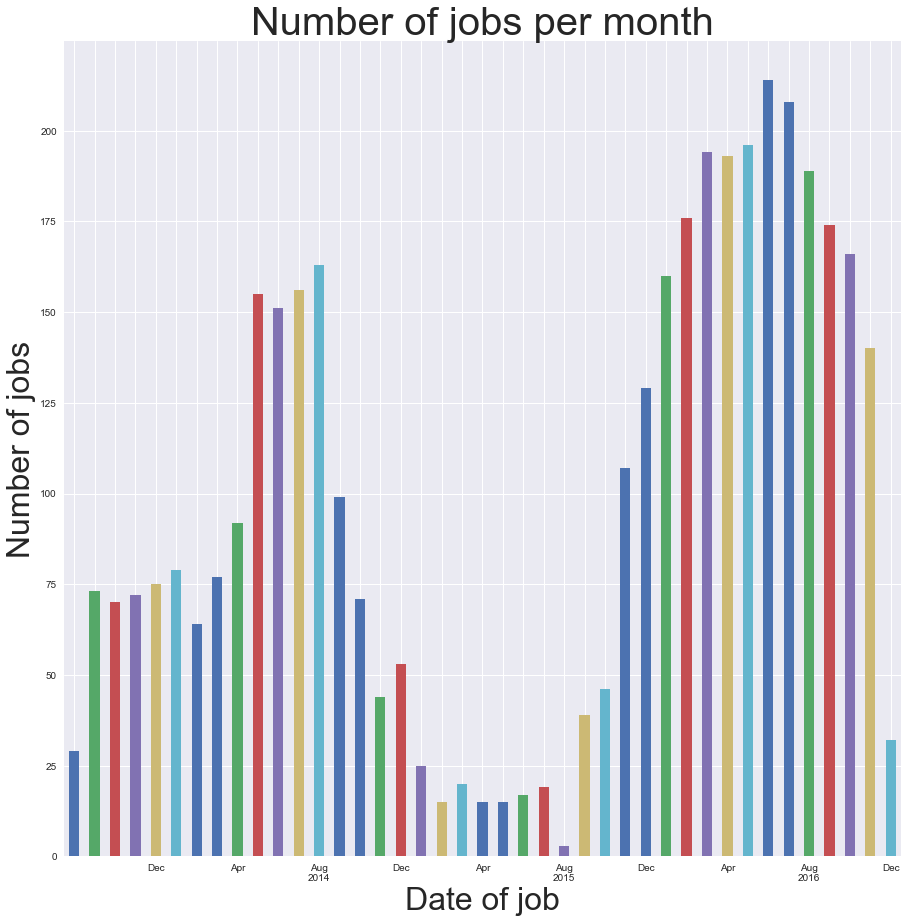

In [86]:
# Create a histogram of the start dates
df = dfJobs['DTSTART'].groupby([dfJobs['DTSTART'].dt.year, dfJobs['DTSTART'].dt.month]).count()
ax = df.plot(kind="bar", rot=0, figsize=(15,15));


plt.xlabel('Date of job', fontsize=32);
plt.ylabel('Number of jobs', fontsize=32);
plt.title('Number of jobs per month', fontsize=40);

# This just customizes our ticker so that the labels aren't squished.
ticklabels = ['']*len(df.index) # Create a list of tick labels the same size as our index
monthLabel = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Every 4th tick shows the month and day
ticklabels[::4] = [monthLabel[item[1]-1] for item in df.index[::4]]
# Every 12th ticklabel includes the year
ticklabels[::12] = ['{}\n{}'.format(monthLabel[item[1]-1], item[0]) for item in df.index[::12]]
# Get rid of first tick
ticklabels[0] = ''
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
#plt.gcf().autofmt_xdate()

# There's definitely a variation in the jobs over time. 

Not as many moving jobs during the winter period. 2015 was a very bad year. Summer better than winter. September through November is worst for jobs. Although in 2016, there was a spike in jobs in 

## Cancelled jobs

Cancelled jobs can be a problem for the business. However, it looks like only 4% of the jobs were listed as cancelled. We may be able to look further into the _summary_ field or _date_ field to learn more about why jobs were cancelled.

In [87]:
print('There were {} cancelled jobs out of {} total jobs({:.2f}%)'.format(sum(dfJobs['CANCELLED']), 
                                                                          len(dfJobs['CANCELLED']), 
                                                                100.0*sum(dfJobs['CANCELLED'])/len(dfJobs['CANCELLED'])))

There were 173 cancelled jobs out of 4015 total jobs(4.31%)


In [88]:
dfJobs.ix[4009]

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


DTSTART                                               2016-12-01 22:00:00
DTEND                                                 2016-12-02 06:00:00
RRULE                                                                None
DTSTAMP                                               2016-11-29 12:31:59
UID                                 mseq63sf79542ehq1isoq6mg94@google.com
CREATED                                               2016-11-29 00:57:30
DESCRIPTION             December 1\, 2016 2:00pm PST\nCalendar: Vector...
ORIGIN                     2870 Fifth Ave. Suite 107 San Diego\, Ca 92103
ORIGIN TYPE                                                        Office
ORIGIN ZIP CODE                                                     92103
DESTINATION                                                          None
DESTINATION TYPE                                                     None
DESTINATION ZIP CODE                                                 None
SIZE                                  

In [26]:
dfJobs.ix[3400]

DTSTART                                               2016-08-14 18:00:00
DTEND                                                 2016-08-15 01:00:00
RRULE                                                                None
DTSTAMP                                               2016-11-29 12:31:59
UID                                 3dgci7jsjbduarpusgmvtlma8s@google.com
CREATED                                               2016-08-09 16:12:55
DESCRIPTION             Jorge N.\, Felix V.\nNAME: Kelly Sprankel\nPHO...
ORIGIN                       2916 Wintergreen Drive\, Carlsbad\, CA 92008
ORIGIN TYPE                                                          None
ORIGIN ZIP CODE                                                     92008
DESTINATION                      1024 Gleneagles Place\, Vista\, CA 92081
DESTINATION TYPE                                                     None
DESTINATION ZIP CODE                                                92081
SIZE                       3 Bedroom (

# Plot the data to Google Maps

# Let's plot the origins

First we need to get all of the latitudes and longitudes of the origin addresses.
The geopy package goes to the internet to try to interpret the address.

In [31]:
#!pip install geopy

In [90]:
# You can use any of the RESTful APIs below to turn the address into latitude/longitude.
# However, some APIs are better at parsing the address. Others limit the number
# of requests per day. Some APIs are better at parsing and figuring out addresses than others.
# The list of supported API interfaces is here: https://github.com/geopy/geopy/tree/master/geopy/geocoders
from geopy.geocoders import ArcGIS  # Lat/long is a few blocks off
#from geopy.geocoders import GoogleV3  # Google only allows 2500 request per day
from geopy.geocoders import Nominatim # OpenStreetMap geocoder - Completely free, no request limits
#from geopy.geocoders import GeocodeFarm  # Limit is 250 request per day on free module
#from geopy.geocoders import GeocoderDotUS  # The US Census Bureau
#from geopy.geocoders import GeoNames  # Requires username

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def getCoordinates(dfJobs, field = 'ORIGIN'):
    
    geolocatorArc = ArcGIS() 
    geolocator = Nominatim()
    #geolocator = GeocoderDotUS()
    #geolocator = GeocodeFarm()
    #geolocator = GeoNames()

    lats = [None]*dfJobs.shape[0]
    longs = [None]*dfJobs.shape[0]

    for i in range(dfJobs.shape[0]):

        place = dfJobs[field].ix[i]

        if place != None:

            '''
            We need to manually correct some of the input so that we can find lat and longitude
            '''
            place = place.strip()
            place = place.lower()
            place = re.sub(r'sd', 'san diego', place)
            place = re.sub(r'coranado', 'coronado', place)
            place = re.sub(r'\(.*?\)', '', place)  # Remove anything in parentheses
            place = re.sub(r'[^0-9a-zA-Z\s]+', '', place)  # Remove anything non alpha-numeric or spaced
            place = re.sub(r'apt\s*\w+', '', place)   # Remove apartment
            place = re.sub(r'unit\s*\w+', '', place)  # Remove unit
            place = re.sub(r'suite\s*\w+', '', place)  # Remove suite
            place = re.sub(r'Ste\s*\w+', '', place)  # Remove ste
            place = re.sub(r'(ca)\s', ', california ', place) # Add comma before california

            # Get rid of everything after the zip code
            st = [m.end(0) for m in re.finditer(r'\d{5}(?:[-\s]\d{4})?', place)]

            if (len(st) != 0) and (st > 0):
                place = place[0:st[-1]] # Only take the last match in case house number has same # digits as zip

            # Remove the middle numbers
            nums = re.findall(r'\d+', place)[1:-1]
            for n in nums:
                place = re.sub(n, '', place)
            
            # Handles the 'To Be Determined' shorthand
            # Often the destination is not known when making the appointment
            # so some sort of text note gets added. Not sure how to differentiate
            # note from a valid address. Most notes do not have digits in them. So let's use that.
            # A valid address has to have at least one digit somewhere.
            if not hasNumbers(place):  # If there are no numbers then this is not an address
                place = ''
                
            #print place
            
            if len(place) > 0:
                
                # Nominatim gives better lats and long, but doesn't parse well.
                location = geolocator.geocode(place, timeout=120)  # Don't timeout for 120 seconds
                if (location is not None):
                    lats[i] = location.latitude
                    longs[i] = location.longitude
                else:
                    # Arc parses well, but is often a few blocks off on lat and long
                    # I think it rounds off the decimal places too much.
                    location = geolocatorArc.geocode(place, timeout=120)  # Don't timeout for 120 seconds
                    if (location is not None):
                        lats[i] = location.latitude
                        longs[i] = location.longitude
                    else:
                        if dfJobs[field + ' ZIP CODE'].ix[i] is not None:
                            # If not found, then lookup through zip code
                            location = geolocator.geocode(dfJobs[field + ' ZIP CODE'].ix[i], timeout=120)
                            if (location is not None):
                                lats[i] = location.latitude
                                longs[i] = location.longitude
                            else:
                                print ('Can''t find: {}'.format(place))
                                
    return [lats, longs]


## Get latitude and longitude of the origin address

In [ ]:
[lats, longs] = getCoordinates(dfJobs, 'ORIGIN')

#Sanity check - San Diego driveable region should be approximately (32 to 34 lat, -108 to -118 long)
lats[lats < 32] = None
lats[lats > 34] = None
longs[longs < -118] = None
longs[longs > -108] = None

dfJobs['ORIGIN LATITUDE'] = lats
dfJobs['ORIGIN LONGITUDE'] = longs

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/geopy/compat.py:150: UserWarning: SSL context is not supported in your environment for urllib calls. Perhaps your Python version is obsolete? This probably means that TLS verification doesn't happen, which is insecure. Please consider upgrading your Python interpreter version.
  UserWarning)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-pac

## Get latitude and longitude of the destination address

In [ ]:
[lats, longs] = getCoordinates(dfJobs, 'DESTINATION')

#Sanity check - San Diego driveable region should be approximately (32 to 34 lat, -108 to -118 long)
lats[lats < 32] = None
lats[lats > 34] = None
longs[longs < -118] = None
long[longs > -108] = None

dfJobs['DESTINATION LATITUDE'] = lats
dfJobs['DESTINATION LONGITUDE'] = longs

## Plot the address locations into a Google Map

In [ ]:
#!pip install gmplot   # Google Maps plotter
import gmplot

gmap = gmplot.GoogleMapPlotter(32.7157, -117.1611, 9)  # Centered on San Diego, CA


#gmap.plot(lats, longs, 'cornflowerblue', edge_width=10) # I think this plots line in between
                                                         # So good for paths

# This code just plots circles at the lat/lon coordinates
gmap.scatter(dfJobs[~dfJobs['ORIGIN LATITUDE'].isnull()]['ORIGIN LATITUDE'], 
             dfJobs[~dfJobs['ORIGIN LATITUDE'].isnull()]['ORIGIN LONGITUDE'], 
             color = 'm', size = 70, marker=False, alpha=0.5)

gmap.scatter(dfJobs[~dfJobs['DESTINATION LATITUDE'].isnull()]['DESTINATION LATITUDE'], 
             dfJobs[~dfJobs['DESTINATION LATITUDE'].isnull()]['DESTINATION LONGITUDE'], 
             color = 'teal', size = 70, marker=False, alpha=0.5)

grad1 = [  # Blue to red gradient
    [0, 255, 255, 0],
    [0, 255, 255, 1],
    [0, 191, 255, 1],
    [0, 127, 255, 1],
    [0, 63, 255, 1],
    [0, 0, 255, 1],
    [0, 0, 223, 1],
    [0, 0, 191, 1],
    [0, 0, 159, 1],
    [0, 0, 127, 1],
    [63, 0, 91, 1],
    [127, 0, 63, 1],
    [191, 0, 31, 1],
    [255, 0, 0, 1]]

# This code adds heatmaps to the lat/lon coordinates
gmap.heatmap(dfJobs[~dfJobs['ORIGIN LATITUDE'].isnull()]['ORIGIN LATITUDE'], 
             dfJobs[~dfJobs['ORIGIN LATITUDE'].isnull()]['ORIGIN LONGITUDE'], 
             radius=10, threshold=10, 
             gradient=grad1)

gmap.heatmap(dfJobs[~dfJobs['DESTINATION LATITUDE'].isnull()]['DESTINATION LATITUDE'], 
             dfJobs[~dfJobs['DESTINATION LATITUDE'].isnull()]['DESTINATION LONGITUDE'], 
             radius=10, threshold=10)

gmap.draw('vectorMovingJobs.html')

In [ ]:
import webbrowser

webbrowser.open_new_tab('vectorMovingJobs.html')

## Save data to CSV file

In [ ]:
#dfJobs.to_csv('VectorMovingJobs.csv')